# **Deep Learning Homework 6: *Variational Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin & Prof. Luca Pasa
---

In this homework, we will explore how to develop a Variational Autoencoder (VAE). We will define a Variational Autoencoder starting from basic PyTorch components. Then, we will define a training loop which includes the two losses used to train VAEs, namely the reconstruction loss and the KL-divergence loss.
Using this training loop, we will fit the model on the MNIST dataset choosing  appropriate hyperparameters. Finally, we will and explore and analyze the latent encodings learned by the model thanks to some visualization techniques.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime type* at the bottom of the page, and then select the GPU hardware accelerator.


#Requirements

In [9]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

#Imports

In [10]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Data Loading and Preprocessing

We load the MNIST dataset. The dataset contains 60,000 training grayscale images and 10,000 testing image of handwritten digits. We chose to use a 128-dimensional batch in order to make the training process reasonably fast -- you should thus leave this value unchanged.

In [12]:
Trns = transforms.ToTensor()
def preprocess(img):
  img = Trns(img)
  H, W = img.shape[1:]
  img = img.reshape((H*W, ))
  return img

MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=preprocess)

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [13]:
batch_size = 128
dataloader = DataLoader(MNIST, batch_size=batch_size, shuffle=True)

Let us see one of the digits:

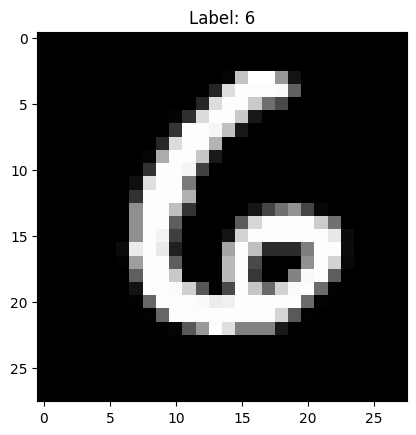

In [14]:
data_iter = iter(dataloader)
images, labels = next(data_iter)

plt.imshow(images[0].reshape(28,28), cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.show()

#[TO COMPLETE] VAE Architecture

###Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define two main parts: the _Encoder_ and the _Decoder_.
Let's start by the Encoder, that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define a Sampling layer as a new layer.

In our case, the Sampling layer has in input the tuple made of the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon \sim \mathcal{N}(0,1)$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.


As usual, we will provide the structure of the implementation of the VAE in PyTorch. The Encoder and Decoder are embodied by the `E_layers` and `D_layers` respectively. Try to understand its structure and functions by yourself, and complete the following task:

**[TO COMPLETE]**: Complete the code of the VAE model defining:

1. the dense layers that model `z_mean` and `z_var`
2. the sampling function that implements the reparametrization trick
3. the reparameterization trick in the forward function.

*Hint*: to generate random values from a normal distribution you can use the PyTorch [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html) function, and make sure the output shape is the proper one.


`%STARTCODE%`

In [15]:
class VAE(nn.Module):
  def __init__(self, input_dim, ENC_LAYERS, latent_dim, DEC_LAYERS, act_fun, last_layer_act_fun):
    super().__init__()

    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.latent_dim = latent_dim

    activation_functions = {'linear':transforms.Lambda(lambda x: x), 'sigmoid':F.sigmoid, 'relu':F.relu, 'tanh': F.tanh, 'leaky_relu': F.leaky_relu}
    assert act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[act_fun]
    self.last_af = activation_functions[last_layer_act_fun]

    for layer_idx in range(len(ENC_LAYERS)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, ENC_LAYERS[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(ENC_LAYERS[layer_idx-1], ENC_LAYERS[layer_idx]))

    ### TO COMPLETE
    # 1. define the dense layers that model z_mean and z_var
    self.linear_mean = nn.Linear(ENC_LAYERS[-1], latent_dim) # [TO COMPLETE]
    self.linear_var = nn.Linear(ENC_LAYERS[-1], latent_dim)# [TO COMPLETE]
    ###


    if len(DEC_LAYERS) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(ENC_LAYERS[-1], input_dim))
    else:
      for layer_idx in range(len(DEC_LAYERS)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(latent_dim, DEC_LAYERS[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(DEC_LAYERS[layer_idx-1], DEC_LAYERS[layer_idx]))

    self.final_fc = nn.Linear(DEC_LAYERS[-1], input_dim)
    self.emb = nn.Embedding(10, 784)

  def sampling(self, z_mean, z_var):
    ### TO COMPLETE
    # 2. write the sampling function that implements the reparametrization trick
    # [TO COMPLETE]
    std = torch.exp(0.5 * z_var)
    eps = torch.randn_like(std)
    z = eps.mul(std).add_(z_mean)
    return z
    ###

  def encode(self, x):
    """This function implmements the encoder part of our VAE.
    It will also be useful to explore the latent space learned after training!
    """
    for layer in self.E_layers:
      x = self.af(layer(x))
    return x

  def decode(self, z):
    """This function implmements the decoder part of our VAE.
    It will also be useful to explore the latent space learned after training!
    """
    for layer in self.D_layers:
      z = self.af(layer(z))

    out = self.final_fc(z)

    return self.last_af(out)

  def forward(self, x):
    x = self.encode(x)

    ### TO COMPLETE
    # 3. use the linear layers and the sampling function you defined above
    # to compute the sample z
    self.z_mean = self.linear_mean(x) # [TO COMPLETE]
    self.z_var = self.linear_var(x) # [TO COMPLETE]
    self.z = self.sampling(self.z_mean, self.z_var) # [TO COMPLETE]
    ###

    return self.decode(self.z)

`%ENDCODE%`



#[TO COMPLETE] Loss Functions

Now we have defined the VAE but, since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the _Kullback-Liebler Divergence_. On the other hand, for the reconstruction loss we will use the _binary cross-entropy_ to compare each feature of a data point to the value in the reconstructed output.

**[TO COMPLETE]**: Implement the reconstruction loss and the KL-divergence.
You have to implement the KL-divergence from scratch, explointing the VAE variables.

`%STARTCODE%`

In [16]:
#let's define the reconstruction loss...
REC_LOSS = nn.BCEWithLogitsLoss(reduction='sum') ### [TO COMPLETE]

#..and the Kullback-Liebler Divergence
def KL_LOSS(model):
  ### [TO COMPLETE]
  loss = -0.5 * torch.sum(1 + model.z_var - torch.pow(model.z_mean, 2) - torch.exp(model.z_var), dim=1)
  loss = torch.mean(loss)
  return loss


`%ENDCODE%`

#[TO COMPLETE] Training

We define the training loop. Notice how we set a $\beta$ parameter to weight the combination of the two losses.

In [17]:
def train(model, optimizer, dataloader, epochs, Beta=1e-3):
  loss_train_rec, loss_train_kl, loss_train = [], [], []

  for epoch in range(epochs):
    model.train()
    n_train_batches, rec_train, kl_train, total_loss_train = 0, 0, 0, 0

    for idx, (img, _) in enumerate(dataloader):

      optimizer.zero_grad()

      img = img.to(device)

      rec_img = model(img)

      rec_loss = REC_LOSS(rec_img, img)
      kl_loss = KL_LOSS(model)

      total_loss = rec_loss + Beta * kl_loss

      total_loss_train += total_loss
      rec_train += rec_loss
      kl_train += kl_loss

      total_loss.backward()
      optimizer.step()

      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    avg_rec_loss_train = rec_train/n_train_batches
    avg_kl_loss_train = kl_train/n_train_batches

    loss_train.append(avg_loss_train.item())
    loss_train_rec.append(avg_rec_loss_train.item())
    loss_train_kl.append(avg_kl_loss_train.item())

    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}", end=' ----- ')
      print(f"Rec Loss: {avg_rec_loss_train:.8f}", end=' ----- ')
      print(f"Effective KL Loss: {Beta * avg_kl_loss_train:.8f}")

  return loss_train, loss_train_rec, loss_train_kl

In [18]:
def plot_losses(loss_train, loss_rec, loss_kl):
  plt.subplot(2, 1, 1)
  plt.grid(True)
  plt.title("Reconstruction Loss")
  plt.plot(loss_rec)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  print("\n")

  plt.subplot(2, 1, 2)
  plt.title("KL Loss")
  plt.grid(True)
  plt.plot(loss_kl)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

**[TO COMPLETE]:**
Your task is to make the VAE working well and learn the digits'representstions. Define the hyperparameters for the encoder and decoder layers. Explain choice for what concerns the number of layers, the layers sizes, and the activation functions in the cells below.

_Hint:_ Note that we should define the `latent_dim` (that is the dimension of $z$) to $2$. This choice is made to make possible to represent the results graphically.
Pay attention to the relation between the decoding and encoding layers.

`%STARTCODE%`

In [22]:
### TO COMPLETE
# ENC_LAYERS and DEC_LAYERS should be lists describing the number and size of
# encoding / decoding layers

input_dim = 784# [TO COMPLETE]
ENC_LAYERS = [1024, 512]# [TO COMPLETE]
DEC_LAYERS = [512, 1024]# [TO COMPLETE]
act_fun = 'tanh'# [TO COMPLETE]
last_layer_act_fun = 'tanh' # [TO COMPLETE]
latent_dim = 2

vae = VAE(input_dim, ENC_LAYERS, latent_dim, DEC_LAYERS, act_fun, last_layer_act_fun).to(device)
summary(vae, input_size=(input_dim, ))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [784]                     7,840
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [1024]                    803,840
│    └─Linear: 2-2                       [512]                     524,800
├─Linear: 1-2                            [2]                       1,026
├─Linear: 1-3                            [2]                       1,026
├─ModuleList: 1-4                        --                        --
│    └─Linear: 2-3                       [512]                     1,536
│    └─Linear: 2-4                       [1024]                    525,312
├─Linear: 1-5                            [784]                     803,600
Total params: 2,668,980
Trainable params: 2,668,980
Non-trainable params: 0
Total mult-adds (G): 2.26
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 10.64
Estimat

Let's train out model:

In [23]:
lr = 1e-3
epochs = 30

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

In [24]:
start = timer()
loss_train, loss_rec, loss_kl = train(vae, optimizer, dataloader, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 41868.79296875 ----- Rec Loss: 41868.77734375 ----- Effective KL Loss: 0.01770810
epoch: 2 -> Loss: 40484.39062500 ----- Rec Loss: 40484.37890625 ----- Effective KL Loss: 0.01586465
epoch: 3 -> Loss: 40070.16796875 ----- Rec Loss: 40070.14062500 ----- Effective KL Loss: 0.01744030
epoch: 4 -> Loss: 39843.17187500 ----- Rec Loss: 39843.16015625 ----- Effective KL Loss: 0.01873060
epoch: 5 -> Loss: 39674.21875000 ----- Rec Loss: 39674.19531250 ----- Effective KL Loss: 0.01973331
epoch: 6 -> Loss: 39546.57812500 ----- Rec Loss: 39546.55859375 ----- Effective KL Loss: 0.02088767
epoch: 7 -> Loss: 39471.81640625 ----- Rec Loss: 39471.80468750 ----- Effective KL Loss: 0.02216388
epoch: 8 -> Loss: 39412.62890625 ----- Rec Loss: 39412.59765625 ----- Effective KL Loss: 0.02325752
epoch: 9 -> Loss: 39350.54296875 ----- Rec Loss: 39350.51953125 ----- Effective KL Loss: 0.02427212
epoch: 10 -> Loss: 39298.82421875 ----- Rec Loss: 39298.81250000 ----- Effective KL Loss: 0.02486241

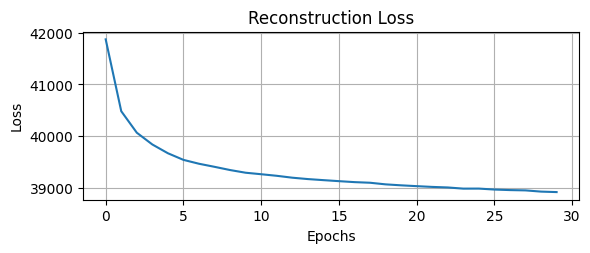

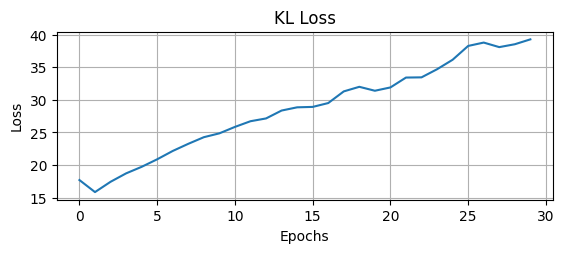

In [25]:
plot_losses(loss_train, loss_rec, loss_kl)

`%ENDCODE%`

`%STARTEXT`

**[TO COMPLETE]** Comment on your choice of number of layers, the layers sizes, and the activation functions.

Answer:
- Single Layer VAE (64 units, ReLU activation): This configuration resulted in a relatively high loss. It seems that a single layer with 64 units might be too simple to effectively capture the complexity of the data.
Single Layer VAE (2048 units, Leaky ReLU activation): Increasing the number of units in the single layer improved the performance slightly, but the loss was still relatively high.
- Two Layer VAE (2048 and 1024 units, ReLU activation): Adding a second layer and using a ReLU activation function further improved the performance. The loss decreased significantly compared to the single layer models.
- Three Layer VAE (2048, 1024, and 512 units, ReLU activation): Adding a third layer did not improve the performance. In fact, the loss increased slightly compared to the two-layer model. This suggests that adding more layers does not necessarily improve the model’s performance and might even lead to overfitting.
- Two Layer VAE (1024 and 512 units, ReLU activation, Tanh activation in the last layer): This configuration resulted in the best performance. The loss was significantly lower than all other configurations. This suggests that using a Tanh activation function in the last layer is best for this task.


In conclusion, the best configuration seems to be a two-layer VAE with 1024 and 512 units, a ReLU activation function, and a Tanh activation function in the last layer.


`%ENDTEXT`

#[TO COMPLETE] Generation

The best part about generative models is that they can generate new data (ChatGPT is pretty good at it). We can therefore plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

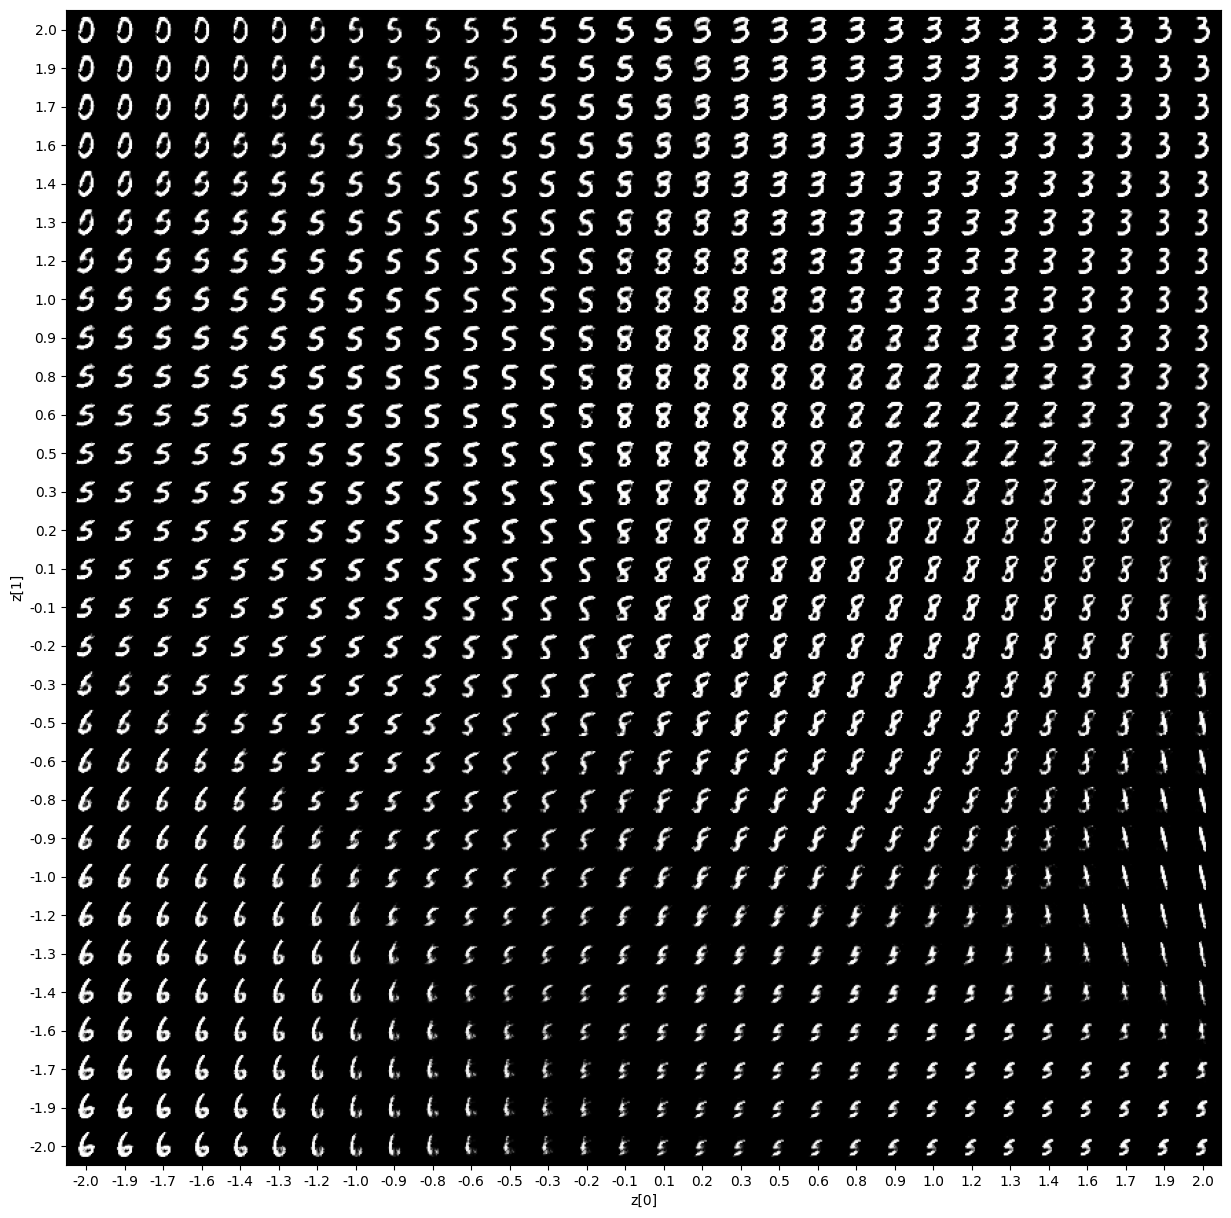

In [26]:
def plot_latent(scale=2.0, n = 30):

    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            with torch.no_grad():
              x_decoded = vae.decode(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size).to('cpu')
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(2.0, 30)

The final result is quite impressive, considering that all these digits are artificial and they not belong to any dataset!
Let's finally check how the various digits have been represented in the latent space by the VAE.

In [27]:
x_train, y_train = next(iter(DataLoader(MNIST, batch_size=len(MNIST))))

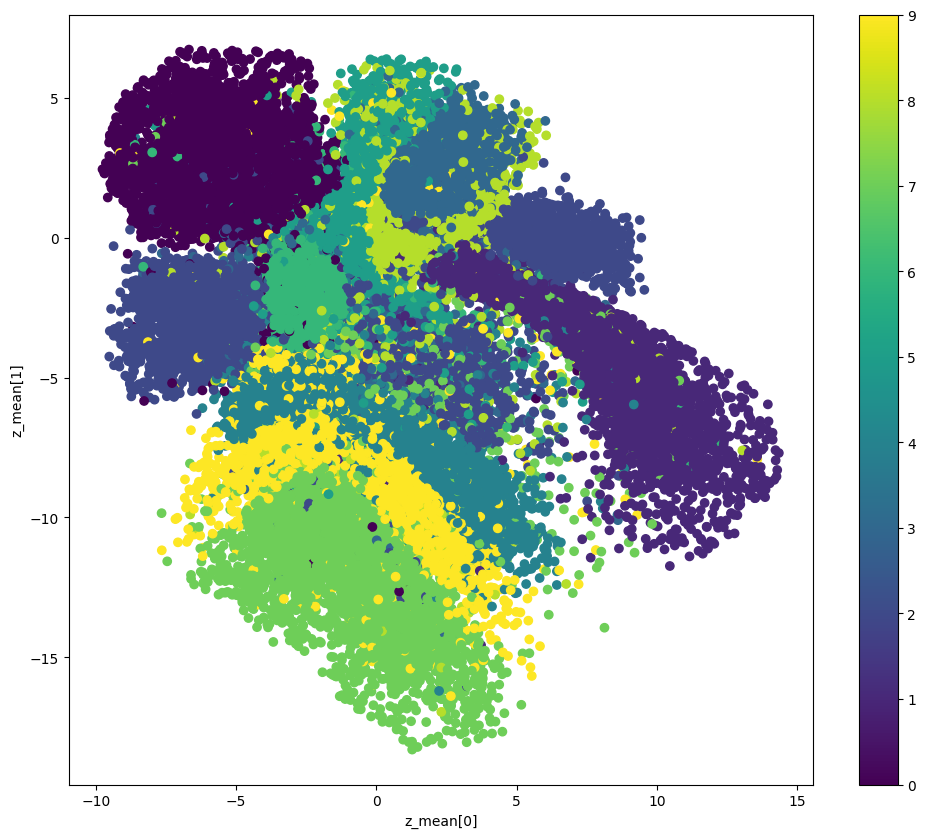

In [28]:
def plot_label_clusters(data, labels):
    with torch.no_grad():
      encoding = vae.encode(data.to(device))
      z_mean = vae.linear_mean(encoding).to('cpu')
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z_mean[0]")
    plt.ylabel("z_mean[1]")
    plt.show()

plot_label_clusters(x_train, y_train)

**[TO COMPLETE]** Explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Discuss the obtained plots, and different hyperparameters you have tried. Insert your discussion below:

`%STARTEXT`

Answer:

Cluster Separation: The effectiveness of a VAE can be gauged by how well it separates distinct clusters in the latent space. In the graph the numbers got well defined only then the clusters were further apart and not overlapping. Furthermore other activation functions like sigmoid had a 'sharper' effect on the graph, I believe that to be simply how sigmoid moves towards infinity when the function goes to 1 or 0.

Like before

- A single layer with 64 units was too simple.
- Increasing to 2048 units improved performance slightly.
- A two-layer VAE with 2048 and 1024 units and ReLU activation function decreased the loss significantly.
- Adding a third layer increased the loss, suggesting potential overfitting.
- The best configuration was a two-layer VAE with 1024 and 512 units, ReLU activation, and Tanh activation in the last layer, which achieved the lowest loss.

`%ENDTEXT`

#[TO COMPLETE] Generation: Conditioned on Text

In the above exercise, we see generative power of VAE. However, we donot have much control over the generation process the model relies on the input data it is trained on. In this excersie we try to control the generation process by explicitly conditioning the model on text.


In [29]:
class VAE_Conditioned(nn.Module):
  def __init__(self, input_dim, ENC_LAYERS, latent_dim, DEC_LAYERS, act_fun, last_layer_act_fun):
    super().__init__()

    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.latent_dim = latent_dim
    self.input_dim = input_dim

    activation_functions = {'linear':transforms.Lambda(lambda x: x), 'sigmoid':F.sigmoid, 'relu':F.relu, 'tanh': F.tanh, 'leaky_relu': F.leaky_relu}
    assert act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[act_fun]
    self.last_af = activation_functions[last_layer_act_fun]

    for layer_idx in range(len(ENC_LAYERS)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, ENC_LAYERS[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(ENC_LAYERS[layer_idx-1], ENC_LAYERS[layer_idx]))

    ### TO COMPLETE
    # 1. define the dense layers that model z_mean and z_var
    self.linear_mean = nn.Linear(ENC_LAYERS[-1], latent_dim)# [TO COMPLETE]
    self.linear_var = nn.Linear(ENC_LAYERS[-1], latent_dim)# [TO COMPLETE]
    ###

    if len(DEC_LAYERS) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(ENC_LAYERS[-1], input_dim))
    else:
      for layer_idx in range(len(DEC_LAYERS)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(latent_dim, DEC_LAYERS[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(DEC_LAYERS[layer_idx-1], DEC_LAYERS[layer_idx]))

    self.final_fc = nn.Linear(DEC_LAYERS[-1], input_dim)
    self.emb = nn.Embedding(10, input_dim)

  def sampling(self, z_mean, z_var):
    ### TO COMPLETE
    # 2. write the sampling function that implements the reparametrization trick
    # [TO COMPLETE]
    std = torch.exp(0.5 * z_var)
    eps = torch.randn_like(std)
    z = eps.mul(std).add_(z_mean)
    return z
    ###

  def encode(self, x):
    """This function implmements the encoder part of our VAE.
    It will also be useful to explore the latent space learned after training!
    """
    for layer in self.E_layers:
      x = self.af(layer(x))
    return x

  def decode(self, z, text):
    """This function implmements the decoder part of our VAE.
    It will also be useful to explore the latent space learned after training!
    """
    for layer in self.D_layers:
      z = self.af(layer(z))

    out = self.final_fc(z)
    text = self.emb(text)
    out = out + text

    return self.last_af(out)

  def forward(self, x, text):
    x = self.encode(x)

    ### TO COMPLETE
    # 3. use the linear layers and the sampling function you defined above
    # to compute the sample z
    self.z_mean = self.linear_mean(x)# [TO COMPLETE]
    self.z_var = self.linear_var(x)# [TO COMPLETE]
    self.z = self.sampling(self.z_mean, self.z_var) # [TO COMPLETE]

    return self.decode(self.z, text)

In [30]:
def train_conditioned(model, optimizer, dataloader, epochs, Beta=1e-3):
  loss_train_rec, loss_train_kl, loss_train = [], [], []

  for epoch in range(epochs):
    model.train()
    n_train_batches, rec_train, kl_train, total_loss_train = 0, 0, 0, 0

    for idx, (img, lb) in enumerate(dataloader):

      optimizer.zero_grad()

      img, lb = img.to(device), lb.to(device)

      rec_img = model(img, lb)

      rec_loss = REC_LOSS(rec_img, img)
      kl_loss = KL_LOSS(model)

      total_loss = rec_loss + Beta * kl_loss

      total_loss_train += total_loss
      rec_train += rec_loss
      kl_train += kl_loss

      total_loss.backward()
      optimizer.step()

      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    avg_rec_loss_train = rec_train/n_train_batches
    avg_kl_loss_train = kl_train/n_train_batches

    loss_train.append(avg_loss_train.item())
    loss_train_rec.append(avg_rec_loss_train.item())
    loss_train_kl.append(avg_kl_loss_train.item())

    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}", end=' ----- ')
      print(f"Rec Loss: {avg_rec_loss_train:.8f}", end=' ----- ')
      print(f"Effective KL Loss: {Beta * avg_kl_loss_train:.8f}")

  return loss_train, loss_train_rec, loss_train_kl

In [94]:
### TO COMPLETE
input_dim = 784# [TO COMPLETE]
ENC_LAYERS = [512,256]# [TO COMPLETE]
latent_dim = 2
DEC_LAYERS = [256,512]# [TO COMPLETE]
act_fun = 'tanh'# [TO COMPLETE]
last_layer_act_fun = 'tanh'# [TO COMPLETE]

vae_con = VAE_Conditioned(input_dim, ENC_LAYERS, latent_dim, DEC_LAYERS, act_fun, last_layer_act_fun).to(device)

In [95]:
lr = 1e-3
epochs = 30

optimizer = torch.optim.Adam(vae_con.parameters(), lr=lr)

In [96]:
start = timer()
loss_train, loss_rec, loss_kl = train_conditioned(vae_con, optimizer, dataloader, epochs, Beta=1e-3)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 42611.51171875 ----- Rec Loss: 42611.49609375 ----- Effective KL Loss: 0.01110112
epoch: 2 -> Loss: 40825.55859375 ----- Rec Loss: 40825.54296875 ----- Effective KL Loss: 0.01282733
epoch: 3 -> Loss: 40290.70703125 ----- Rec Loss: 40290.69921875 ----- Effective KL Loss: 0.01426342
epoch: 4 -> Loss: 39949.14453125 ----- Rec Loss: 39949.12500000 ----- Effective KL Loss: 0.01534271
epoch: 5 -> Loss: 39719.84765625 ----- Rec Loss: 39719.83203125 ----- Effective KL Loss: 0.01607162
epoch: 6 -> Loss: 39551.09375000 ----- Rec Loss: 39551.06640625 ----- Effective KL Loss: 0.01688502
epoch: 7 -> Loss: 39440.62890625 ----- Rec Loss: 39440.60546875 ----- Effective KL Loss: 0.01763873
epoch: 8 -> Loss: 39349.75000000 ----- Rec Loss: 39349.71875000 ----- Effective KL Loss: 0.01820769
epoch: 9 -> Loss: 39271.53906250 ----- Rec Loss: 39271.52343750 ----- Effective KL Loss: 0.01893811
epoch: 10 -> Loss: 39211.71484375 ----- Rec Loss: 39211.69140625 ----- Effective KL Loss: 0.01949413

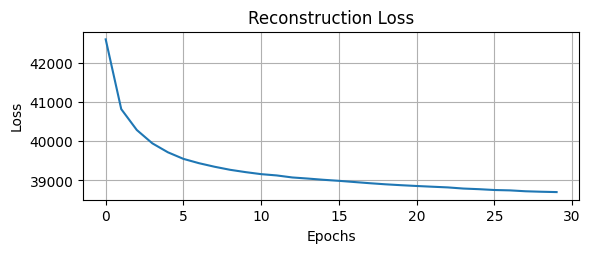

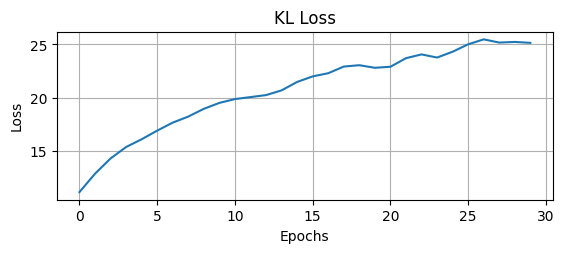

In [97]:
plot_losses(loss_train, loss_rec, loss_kl)

In [98]:
def generate(text='one', n = 2):

    query = {'zero': torch.tensor([0], device=device),
             'one': torch.tensor([1], device=device),
             'two': torch.tensor([2], device=device),
             'three': torch.tensor([3], device=device),
             'four': torch.tensor([4], device=device),
             'five': torch.tensor([5], device=device),
             'six': torch.tensor([6], device=device),
             'seven': torch.tensor([7], device=device),
             'eight': torch.tensor([8], device=device),
             'nine': torch.tensor([9], device=device)
             }

    text = query[text.lower()]

    digit_size = 28
    figsize = 4
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.random.rand(n)
    grid_y = np.random.rand(n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            with torch.no_grad():
              x_decoded = vae_con.decode(z_sample, text)
            digit = x_decoded[0].reshape(digit_size, digit_size).to('cpu')
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


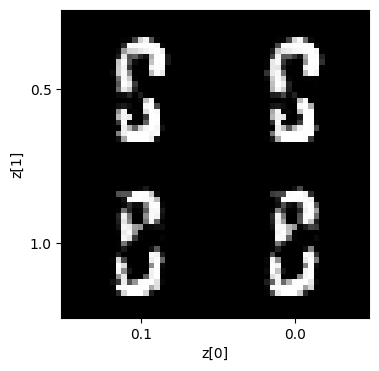

In [99]:
generate('zero')

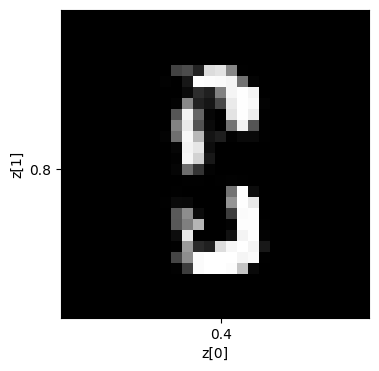

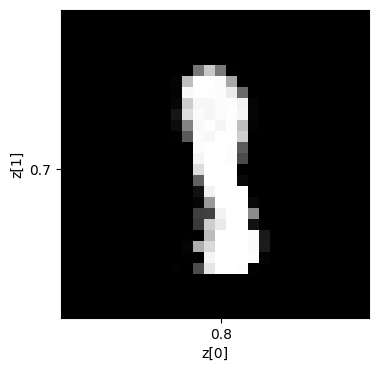

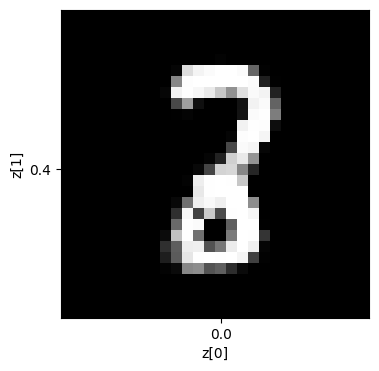

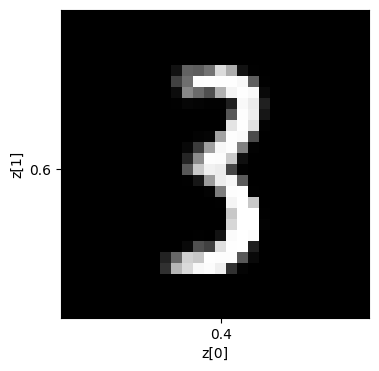

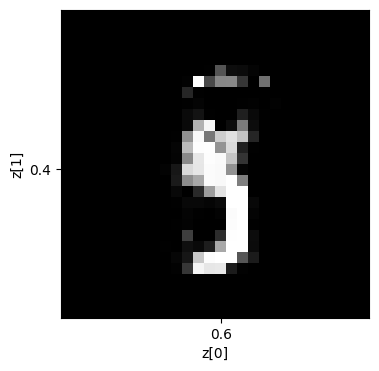

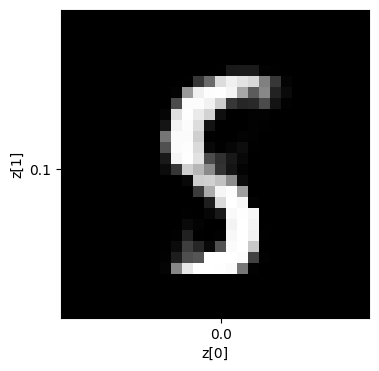

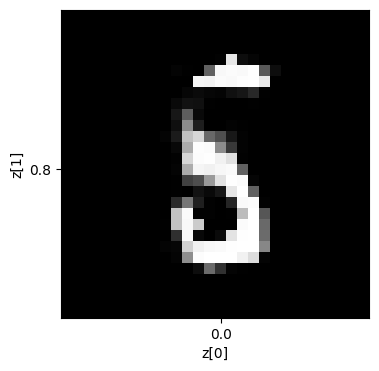

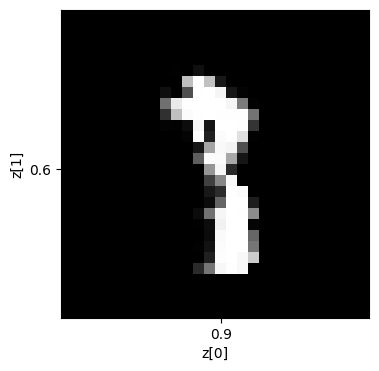

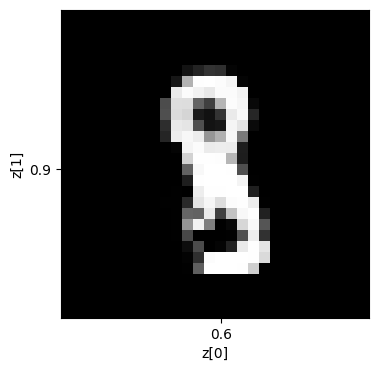

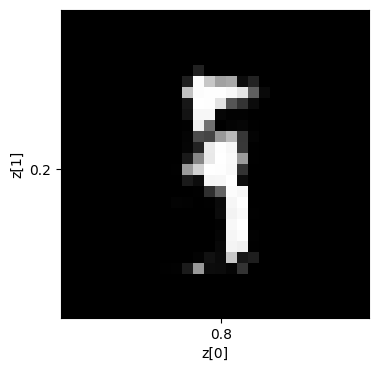

In [100]:
numbers = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
for num in numbers:
  generate(num, 1)

**[TO COMPLETE]** Explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result.

`%STARTEXT`

Answer:
Here are the relevant models I tried:
- VAE with 2 layers (512, 256 units), Sigmoid activation, Linear last layer activation: The model was too simple, and the generated numbers were not distinguishable.
- VAE with 2 layers (512, 256 units), ReLU activation, Tanh last layer activation: The numbers generated were more distinguishable than the previous configuration, but still not clear.
- VAE with 2 layers (512, 256 units), ReLU activation, Tanh last layer activation: The numbers generated were clearer, but they all seemed to resemble the number 9.
- VAE with 2 layers (1024, 512 units), ReLU activation, Tanh last layer activation: The numbers generated were very defined but still didn’t make sense.
- VAE with 2 layers (1024, 512 units), Tanh activation, Tanh last layer activation: The KL divergence was constant, the result was good and sharp, and more than half the numbers were recognizable.
- VAE with 2 layers (1024, 256 units), Tanh activation, Tanh last layer activation: The numbers generated were more blocky, but only 3 numbers were wrong.
- VAE with 3 layers (1024, 512, 256 units), Tanh activation, Tanh last layer activation: The test of zero was still not clean.
- VAE with 4 layers (1024, 512, 256, 64 units), Tanh activation, Tanh last layer activation: The performance worsened, suggesting that the bottleneck was not effective.
- VAE with 2 layers (1024, 512 units), Tanh activation, Linear last layer activation: Despite the metrics being very promising, everything was a gray blob.
- VAE with 2 layers (1024, 512 units), Sigmoid activation, Sigmoid last layer activation: The numbers generated were barely legible.
- VAE with 2 layers (1024 units), Tanh activation, Tanh last layer activation: The numbers generated were just spots, but the numbers could be understood.


In conclusion
- Number of layers: A two-layer architecture for both the encoder and decoder seemed to perform the best. Adding more layers did not necessarily improve performance and sometimes led to worse results, possibly due to overfitting.
- Layer sizes: For the two-layer architecture, sizes of 1024 and 512 units for the encoder and decoder layers worked well.
- Activation functions: The Tanh activation function for both the hidden layers and the last layer yielded the best results. It provided a good balance between linear and non-linear transformations.

`%ENDTEXT`